In [1]:
%%bash --bg
roscore

Starting job # 0 in a separate thread.


In [2]:
%%bash --bg
rosrun stage_ros stageros -g maps/stage/maze.world

Starting job # 2 in a separate thread.


In [3]:
%%bash
rosparam set use_sim_time true

In [4]:
%%bash --bg
rosrun map_server map_server maps/maze.yaml

Starting job # 3 in a separate thread.


In [17]:
!rostopic info /base_pose_ground_truth

Type: nav_msgs/Odometry

Publishers: 
 * /stageros (http://jupyter-robinlabuji-2dros-2dstage-2diqcwukmj:34132/)

Subscribers: 
 * /listener_36_1519382895683 (http://jupyter-robinlabuji-2dros-2dstage-2diqcwukmj:41455/)




In [6]:
!rosnode list

/map_server_1519382885982078889
/rosout
/stageros


In [7]:
import rospy
from nav_msgs.msg import MapMetaData, OccupancyGrid, Odometry
from sensor_msgs.msg import LaserScan

def cb_MapMetaData(data):
    global mmd
    mmd = data
    
def cb_OccupancyGrid(data):
    global og
    og = data.data
    
def cb_Pose(data):
    global pose
    pose = data.pose.pose
    
def cb_Scan(data):
    global scan
    scan = data

In [8]:
rospy.init_node('listener', anonymous=True)

In [9]:
rospy.Subscriber('/map_metadata', MapMetaData, cb_MapMetaData)
rospy.Subscriber('/map', OccupancyGrid, cb_OccupancyGrid)
rospy.Subscriber('/base_pose_ground_truth', Odometry, cb_Pose)
rospy.Subscriber('/base_scan', LaserScan, cb_Scan)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

def pixel(x, y, mmd):
    xp = x / mmd.resolution
    yp = y / mmd.resolution
    return (xp, yp)

def plot_stage():
    plt.rcParams["figure.figsize"] = (6,6)
    plt.clf();
    m = np.array(og)
    m = 100 - m.reshape((200, 200))
    plt.imshow(m, origin='lower', cmap='gray');
    plt.axis('off');
    (x, y) = pixel(pose.position.x, pose.position.y, mmd)
    base_angle = np.arctan2(pose.orientation.z, pose.orientation.w) * 2
    plt.plot(x,y,'ro');
    angles = np.arange(len(scan.ranges)) * scan.angle_increment + scan.angle_min + base_angle
    ranges = np.array(scan.ranges)
    x = np.append([0], scan.ranges * np.cos(angles)) + pose.position.x
    y = np.append([0], scan.ranges * np.sin(angles)) + pose.position.y
    (x, y) = pixel(x, y, mmd)
    plt.fill(x,y,'c.')
    display.display(plt.gcf())
    display.clear_output(wait=True)

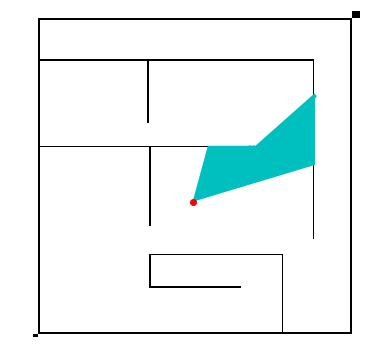

In [39]:
from geometry_msgs.msg import Twist

rate = rospy.Rate(10) # 10hz
pub = rospy.Publisher('cmd_vel', Twist, queue_size=10)
twist = Twist()
twist.linear.x = 0.50
twist.angular.z = 0.0
for i in range(20):
    pub.publish(twist)
    plot_stage()
    rate.sleep()

In [40]:
from ipywidgets import interact

In [50]:
def f(linear, angular):
    twist.linear.x = linear
    twist.angular.z = angular
    pub.publish(twist)
    plot_stage()

In [51]:
interact(f, linear=(-1.0,1.0,0.1), angular=(-1.0,1.0,0.1))

interactive(children=(FloatSlider(value=0.0, description=u'linear', max=1.0, min=-1.0), FloatSlider(value=0.0, description=u'angular', max=1.0, min=-1.0), Output()), _dom_classes=('widget-interact',))

<function __main__.f>